# Simple diagnostic pulse
-> Calculation of control fields for state-to-state transfer of a single qubit system using CRAB algorithm  
Objective: 
- show that the algorithm is indeed running optimization. 
- recover analytically solvable state-to-state transfer using pulse optimization

Example to demonstrate using the control library to determine control pulses using the ctrlpulseoptim.optimize_pulse_unitary function. The CRAB algorithm is used to optimize pulse shapes to minimize the fidelity error, which is equivalent maximising the fidelity to an optimal value of 1.

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [24]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
import random
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip

example_name = '2qubitInteract'

# Defining the physics
System: single qubit  
Hamiltonian: 
$$
H(t) = \frac{\hbar \omega_0}{2} \sigma_z + \epsilon_x(t)\sigma_x + \epsilon_y(t)\sigma_y 
$$
where, $\epsilon_x(t), \epsilon_y(t)$ are control pulses.  

Consider special case: 
$$
H_1(t) = \frac{\hbar \omega_0}{2} \sigma_z + \frac{\hbar \omega_1}{2}(\sigma_x\cos{\omega t} + \sigma_y\sin{\omega t})
$$
From Valerio's note, via frame rotation, if $\ket{\psi_{init}} = \ket{+\hat{z}}$, we have evoloved state, 
$$
|\psi(t)\rangle=e^{-i \omega t / 2}[\cos (\Omega t / 2)-i \cos \theta \sin (\Omega t / 2)]|+\hat{z}\rangle-i e^{i \omega t / 2} \sin \theta \sin (\Omega t / 2)|-\hat{z}\rangle
$$
where, 
$$
\Omega=\sqrt{\left(\omega_0-\omega\right)^2+\omega_1^2} \\
\cos \theta=\frac{\omega_0-\omega}{\Omega}
$$

Suppose we want to achieve a state-to-state transfer from $\ket{+\hat{z}}$ to $\ket{-\hat{z}}$,  
$$
P_{+\hat{z} \rightarrow-\hat{z}}(t) = \sin ^2 \theta \sin ^2(\Omega t / 2)=\left(\frac{\omega_1}{\Omega}\right)^2 \sin ^2(\Omega t / 2)
$$
With $H_1(t)$, $P_{+\hat{z} \rightarrow-\hat{z}}(t)$ only goes to 1 if 
1. $\omega_1 = \Omega$, i.e. $\omega = \omega_0$.
2. $\omega_1 = \frac{\pi}{T}$ (with evolution time T fixed, smallest frequency needed)


## Pulse optimization
Run pulse optimization and compare with analytical result.
Let t = evo_time = T


Defining the time evolution parameters:
- To solve the evolution the control amplitudes are considered constant within piecewise timeslots, hence the evolution during the timeslot can be calculated using U(t_k) = expm(-iH(t_k)dt). 
- Combining these for all the timeslots gives the approximation to the evolution from an initial state ψ0 at t=0 to U(T)ψ0 at the t=evo_time. The number of timeslots and evo_time have to be chosen such that the timeslot durations (dt) are small compared with the dynamics of the system.
- set drift frequency $\omega_0$ to some number, at resonance $\omega = \omega_0$, for state to state transfer to happen at the end of pulse, require $\omega_1 = \frac{\pi}{T}$.

In [25]:
w0 = 1.0 # drift frequency

sx = sigmax()
sy = sigmay()
sz = sigmaz()

# drift Haniltonian
H_d = w0 * sz
# list of control Hamiltonian terms
H_c = [sx,sy]
# Number of ctrls
n_ctrls = len(H_c) 

# initial state & target state
psi_0 = qutip.basis(2,0)
psi_targ = qutip.basis(2,1)

# Defining the time evolution parameters:
# Number of time slots
n_ts = 1000
# Time allowed for the evolution
evo_time = 18

dt = evo_time/n_ts
print("Time step: ", dt, "seconds")

Time step:  0.018 seconds


# Set the conditions which will cause the pulse optimisation to terminate
At each iteration the fidelity of the evolution is tested by comparaing the calculated evolution U(T) with the target U_targ. For unitary systems such as this one this is typically: f = normalise(overlap(U(T), U_targ)). The maximum fidelity (for a unitary system) calculated this way would be 1, and hence the error is calculated as fid_err = 1 - fidelity. As such the optimisation is considered completed when the fid_err falls below such a target value.

In some cases the optimisation either gets stuck in some local minima, or the fid_err_targ is just not achievable, therefore some limits are set to the time/effort allowed to find a solution.

The algorithm uses the CRAB algorithm to determine optimized coefficients that lead to a minimal fidelity error. The underlying optimization procedure is set to be the Nelder-Mead downhill simplex. Therefore, when all vertices shrink together, the algorithm will terminate.

In [26]:
# Fidelity error target
fid_err_targ = 1e-6
# Maximum iterations for the optisation algorithm
max_iter = 10000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120

# Set the initial pulse type
The control amplitudes must be set to some initial values. Typically these are just random values for each control in each timeslot. These do however result in erratic optimised pulses.  
-> For this example, a solution will be found for any initial pulse, and so it can be interesting to look at the other initial pulse alternatives.  

In [27]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'SINE'

# Give an extension for output files

In [28]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

# Run the optimisation
In this step, the actual optimization is performed.   
At each iteration the <u>Nelder-Mead algorithm</u> calculates a new set of coefficients that improves the currently worst set among all set of coefficients. For details see [1,2] and a textbook about static search methods. 
The algorithm continues until one of the termination conditions defined above has been reached. If undesired results are achieved, rerun the algorithm and/or try to change the number of coefficients to be optimized for, as this is a very crucial parameter.  

In [29]:
# CRAB
# result = cpo.opt_pulse_crab_unitary(H_d, H_c, psi_0, psi_targ, n_ts, evo_time, 
#                 fid_err_targ=fid_err_targ, 
#                 max_iter=max_iter, max_wall_time=max_wall_time, 
#                 init_coeff_scaling=1.0, num_coeffs=1, # ???
#                 method_params={'xtol':1e-3},
#                 guess_pulse_type=p_type, guess_pulse_action='modulate', # ???
#                 out_file_ext=f_ext,
#                 log_level=log_level, gen_stats=True)

# GRAPE
result = cpo.optimize_pulse_unitary(H_d, H_c, psi_0, psi_targ,
                 n_ts, evo_time, 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                method_params={'xtol':1e-3},
                init_pulse_type=p_type,
                out_file_ext=f_ext,
                log_level=log_level, gen_stats=True)

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]
Control 1 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
Control 2 Hamiltonian:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]
Initial state / operator:
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]
Target state 

# Report the results
Firstly the <u>performace statistics</u> are reported, which gives a breakdown of the processing times. In this example it can be seen that the majority of time is spent calculating the propagators, i.e. exponentiating the combined Hamiltonian.

The <u>optimised U(T)</u> is reported as the 'final evolution', which is essentially the string representation of the Qobj that holds the full time evolution at the point when the optimisation is terminated.

The key information is in the summary (given last). Here the final fidelity is reported and the reason for termination of the algorithm.

In [30]:
######## report CRAB result ########
# result.stats.report()
# print("Final evolution\n{}\n".format(result.evo_full_final))
# print("********* Summary *****************")
# print("Final fidelity error {}".format(result.fid_err))
# print("Final gradient normal {}".format(result.grad_norm_final))
# print("Terminated due to {}".format(result.termination_reason))
# print("Number of iterations {}".format(result.num_iter))
# print("Completed in {} HH:MM:SS.US".format(
#         datetime.timedelta(seconds=result.wall_time)))


######## report GRAPE result ########
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.699273
Wall time computing Hamiltonians: 0:00:00.024489 (3.50%)
Wall time computing propagators: 0:00:00.494562 (70.73%)
Wall time computing forward propagation: 0:00:00.003139 (0.45%)
Wall time computing onward propagation: 0:00:00.002784 (0.40%)
Wall time computing gradient: 0:00:00.023663 (3.38%)

**** Iterations and function calls ****
Number of iterations: 4
Number of fidelity function calls: 6
Number of times fidelity is computed: 6
Number of gradient function calls: 5
Number of times gradients are computed: 5
Number of times timeslot evolution is recomputed: 6

**** Control amplitudes ****
Number of control amplitude updates: 5
Mean number of updates per iteration: 1.25
Number of timeslot values changed: 5000
Mean number of timeslot changes per update: 1000.0
Number of amplitude values changed: 10000
Mean number of amplit

# Plot the initial and final amplitudes
Here the (random) starting pulse is plotted along with the pulse (control amplitudes) that was found to produce the target gate evolution to within the specified error.

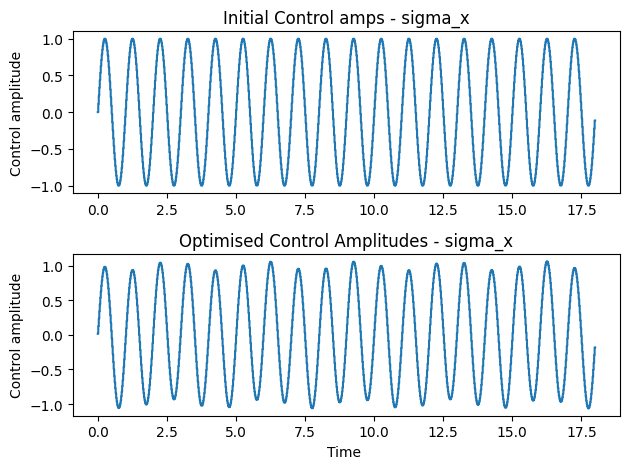

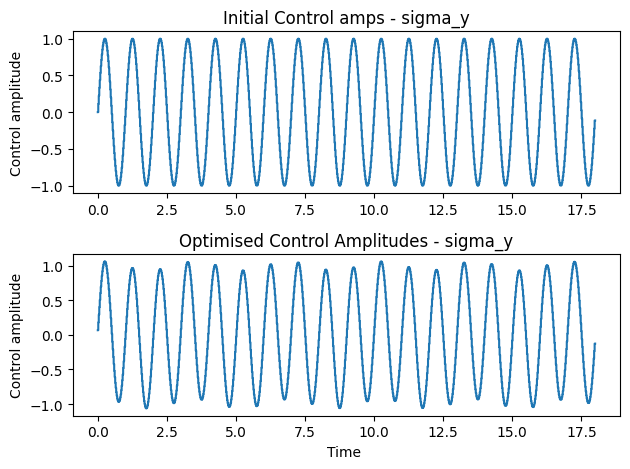

In [31]:
# sigma_x 
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps - sigma_x")
ax1.set_ylabel("Control amplitude")
ax1.step(result.time, 
         np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])), 
         where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes - sigma_x")
ax2.set_xlabel("Time ")
ax2.set_ylabel("Control amplitude")
ax2.step(result.time, 
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])), 
         where='post')
plt.tight_layout()

# sigma_y
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps - sigma_y")
ax1.set_ylabel("Control amplitude")
ax1.step(result.time, 
         np.hstack((result.initial_amps[:, 1], result.initial_amps[-1, 1])), 
         where='post')

ax2 = fig2.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes - sigma_y")
ax2.set_xlabel("Time ")
ax2.set_ylabel("Control amplitude")
ax2.step(result.time, 
         np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1])), 
         where='post')
plt.tight_layout()

plt.show()

# Simulate time evolution using optimized control pulse
For this case, consider QobjEvo with "Array dependence"

In [32]:
# H_c amplitudes (from pulse optimization)
amplitudes_x = result.final_amps[:, 0]
amplitudes_y = result.final_amps[:, 1]

tlist = np.linspace(0, evo_time, n_ts)
H_array_form = qutip.QobjEvo([H_d, [H_c[0], amplitudes_x],[H_c[1], amplitudes_y]], tlist=tlist)

# res = qt.mesolve(H_array_form, psi_0, tlist)
res = qutip.sesolve(H_array_form, psi_0, tlist)

# see fidelity at the end
# qt.metrics.fidelity(res.states[-1].unit(), psi_targ.unit())
# see fidelity at each time step
for i in range(0, n_ts):
    print(i, qutip.metrics.fidelity(res.states[i].unit(), psi_targ.unit()))

0 0.0
1 0.002568586286458641
2 0.007905344095639427
3 0.015997541849054876
4 0.0267563904089771
5 0.040050291443145224
6 0.05570980727607211
7 0.07353005419419845
8 0.09327319169064707
9 0.1146715595572598
10 0.13743164656521611
11 0.16123892626969835
12 0.18576349595264616
13 0.21066635071745046
14 0.23560601958548222
15 0.26024539429956506
16 0.28425881707024186
17 0.30733800086763235
18 0.3291976545826965
19 0.3495801701956635
20 0.36825927442220563
21 0.3850426322876458
22 0.39977347687455256
23 0.4123314224829145
24 0.4226326893874131
25 0.43063001344598606
26 0.4363125291529253
27 0.43970589556897577
28 0.44087290949176405
29 0.43991472104329366
30 0.43697268407371725
31 0.43223085951250895
32 0.42591876848519117
33 0.41831385827798445
34 0.4097429137454032
35 0.4005812623783044
36 0.39124823558088423
37 0.3821970765510611
38 0.37389752467691273
39 0.3668100051145427
40 0.3613520506152333
41 0.3578602867011922
42 0.3565542943447768
43 0.35751038595279083
44 0.3606522549930559
45 

# Compare numerical pulse with analytical pulse (NOT DONE) -> don't think this idea is gonna work
Recall analytical solution expects:  
Suppose we want to achieve a state-to-state transfer from $\ket{+\hat{z}}$ to $\ket{-\hat{z}}$,  
$$
P_{+\hat{z} \rightarrow-\hat{z}}(t) = \sin ^2 \theta \sin ^2(\Omega t / 2)=\left(\frac{\omega_1}{\Omega}\right)^2 \sin ^2(\Omega t / 2)
$$
With $H_1(t)$, $P_{+\hat{z} \rightarrow-\hat{z}}(t)$ only goes to 1 if $\omega_1 = \Omega$, i.e. $\omega = \omega_0$.

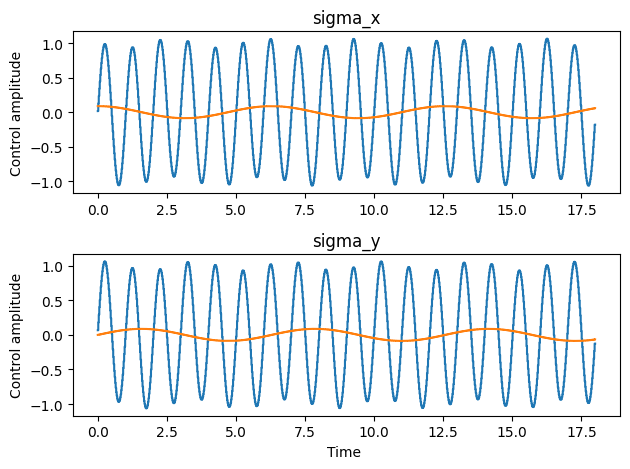

In [33]:

# from analytical solution
w1 = np.pi / evo_time

######## sigma_x ########
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("sigma_x")
ax1.set_ylabel("Control amplitude")
ax1.step(result.time, 
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])), 
         where='post')
ax1.step(result.time, 
         w1 / 2 * np.cos(w0*result.time), 
         where='post')

######## sigma_y ########
ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("sigma_y")
ax2.set_xlabel("Time ")
ax2.set_ylabel("Control amplitude")
ax2.step(result.time, 
         np.hstack((result.final_amps[:, 1], result.final_amps[-1, 1])), 
         where='post')
ax2.step(result.time, 
         w1 / 2 * np.sin(w0*result.time), 
         where='post')
plt.tight_layout()
plt.show()



